# TFIM 分割中の状態をトラッキングする

In [48]:
import qutip as qt
import numpy as np
from pathlib import Path
from datetime import datetime
import matplotlib as mpl
from matplotlib.ticker import MultipleLocator
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
from matplotlib.gridspec import GridSpec

In [49]:
# --------------------
# パラメータ
# --------------------
hx = 0.1
N  = 6
T_cut = 3000.0
nt = 400
tlist = np.linspace(0.0, float(T_cut), int(nt))
J = 1.0
eig_idxes = [0, 1, 2, 3, 4]
Jp_list_data = np.linspace(J, 0.0, int(nt))

In [50]:
def H_tfim_with_cut(N, J, J_p, hx):
    cut_pos = N // 2 - 1
    sx, sz = qt.sigmax(), qt.sigmaz()
    I2 = qt.qeye(2)

    def op_at(i, op):
        return qt.tensor([op if k == i else I2 for k  in range(N)])

    Sx = [op_at(i, sx) for i in range(N)]
    Sz = [op_at(i, sz) for i in range(N)]

    def Hex(i):
        return Sz[i] * Sz[i+1]

    H_cut = Hex(cut_pos)
    H_ex_rest = sum(Hex(i) for i in range(N-1) if i != cut_pos)
    H_trans = sum(Sx[i] for i in range(N))

    return - J * H_ex_rest - J_p * H_cut - hx * H_trans
# mpl.rcParams.update(mpl.rcParamsDefault)
# plt.style.use('default')
# mpl.rcParams.update({
#     "axes.labelsize": 18,   # 軸ラベル
#     "xtick.labelsize": 16,  # 目盛り数字
#     "ytick.labelsize": 16,
#     "lines.linewidth": 2.2, # 線の太さ
#     "axes.titlesize": 16,
# })

# def label_at(ax, x, y, text, *, coord='data', dx_pt = 8, fontsize=14, color=None):
#     kw = dict(ha='left', va='center', fontsize=fontsize, xytext=(dx_pt, 0), textcoords='offset points', path_effects=[pe.withStroke(linewidth = 3, foreground='white')], clip_on=False, zorder=6)
#     if color is not None:
#         kw['color'] = color
#     if coord == 'axes':
#         ax.annotate(text, xy = (x, y), xycoords = ax.transAxes, **kw)
#     else:
#         ax.annotate(text, xy = (x, y), xycoords = 'data', **kw)

# def inward_ticks(ax, major_len=7, minor_len=4, width=1.2):
#     ax.minorticks_on()
#     ax.tick_params(which='both', direction='in', top=True, right=True, length=major_len, width=width)
#     ax.tick_params(which='minor', length=minor_len, width=width)


# OUTPATH = f"../data/tfim/dispersion_N{N}.npz"
dim = 2 ** N
psi_data = np.empty((len(Jp_list_data), dim, dim), dtype=complex)
for j, Jp in enumerate(Jp_list_data):
    H = H_tfim_with_cut(N, J, Jp, hx)
    evals, estates = H.eigenstates(sparse=False, sort='low')
    psi_data[j] = np.stack([st.full().ravel() for st in estates], axis=0)
psi_data = psi_data / np.linalg.norm(psi_data, axis=2, keepdims=True)

# np.savez(OUTPATH, J_p=J_p_list, eigvecs=Psi_all)

# for i, N in enumerate(N_list):
    # fig, ax = plt.subplots(figsize=(6.9, 4.6))
    # results = np.array([simulate(N, J, J_p, hx) for J_p in J_p_list])
    # ax.plot(J_p_list, results, label=f"N = {N}", linewidth=2.0)
    # ax.set_xlim(J_p_list.max(), J_p_list.min())
    # ax.set_xlabel(r"$J^'$", fontsize=24)
    # ax.set_ylim(results.min() - 0.1, results.max() + 0.1)
    # ax.set_ylabel(r"$E_n$", fontsize=24)
    # ax.xaxis.set_major_locator(MultipleLocator(0.1))
    # ax.xaxis.set_minor_locator(MultipleLocator(0.05))
    # ax.yaxis.set_major_locator(MultipleLocator(1.0))
    # ax.yaxis.set_minor_locator(MultipleLocator(0.2))
    # inward_ticks(ax)
    # plt.show()

    # header = "Jp," + ",".join(f"E{b}" for b in range(results.shape[1]))
    # data = np.column_stack([J_p_list, results[1]])
    # np.savez_compressed(OUTDIR/f"dispersion_N{N}.npz", N=N, J=J, hx=hx, Jp=J_p_list, E=results)
    # print("done")


In [51]:
def simulate(N, J, hx, T_cut, nt):
    cut_pos = N // 2 - 1
    sx, sz = qt.sigmax(), qt.sigmaz()
    I2 = qt.qeye(2)

    def op_at(i, op):
        return qt.tensor([op if k == i else I2 for k in range(N)])

    Sx = [op_at(i, sx) for i in range(N)]
    Sz = [op_at(i, sz) for i in range(N)]

    def H_exchange(i):  # 近接相互作用
        return (Sz[i] * Sz[i+1])

    H_cut_unit   = H_exchange(cut_pos)
    H_ex_rest    = sum(H_exchange(i) for i in range(N-1) if i != cut_pos)
    H_trans_unit = sum(Sx[i] for i in range(N))

    # t=0 のフル結合ハミルトニアン（初期状態をとる用）
    H_full   = -J * (H_ex_rest + H_cut_unit) - hx * H_trans_unit
    # 時間依存部を除いた静的パート（= J'に依らない部分）
    H_static = -J * (H_ex_rest) - hx * H_trans_unit

    # 初期状態：t=0 の基底
    _, psi0 = H_full.groundstate(sparse=True)

    # ramp: 切断ボンドの係数を 1→0 に
    def ramp(t, T_cut):
        if T_cut <= 0.0:     # 無発展（瞬間クエンチ直後は psi0 のまま）
            return 0.0 if t > 0.0 else 1.0
        if t <= 0.0:  return 1.0
        if t >= T_cut: return 0.0
        return 1.0 - t / T_cut

    # 時間依存ハミルトニアン：H(t) = H_static + (-J * ramp) * H_cut_unit
    H_t = [H_static, [-J * H_cut_unit, lambda t, args: ramp(t, T_cut)]]
    
    # 固い系向けの設定で積分を安定化
    opts = qt.Options(
        method='bdf',            # ← ここが効きます（デフォは 'adams'）
        rtol=1e-6,
        atol=1e-8,
        nsteps=nt,           # 十分大きく
        # max_step=max(1e-6, float(T_cut)/50.0),  # ステップ制限（粗すぎを防ぐ）
        store_states=True,
        progress_bar=None,
    )

    tlist = np.linspace(0.0, float(T_cut), int(nt))
    result = qt.sesolve(H_t, psi0, tlist, options=opts)

    Jp_list_sim = J * np.array([ramp(t, T_cut) for t in tlist], dtype=float)

    psi_sim = np.array([s.full().ravel() for s in result.states], dtype=complex)
    psi_sim = psi_sim / np.linalg.norm(psi_sim, axis=1, keepdims=True)
    return Jp_list_sim, psi_sim

In [52]:
def inward_ticks(ax, major_len=7, minor_len=4, width=1.2):
    ax.minorticks_on()
    ax.tick_params(which='both', direction='in', top=True, right=True, length=major_len, width=width)
    ax.tick_params(which='minor', length=minor_len, width=width)
    
mpl.rcParams.update(mpl.rcParamsDefault)
plt.style.use('default')
mpl.rcParams.update({
    "axes.labelsize": 18,   # 
    "xtick.labelsize": 16,  # 目盛り数字
    "ytick.labelsize": 16,
    "lines.linewidth": 2.2, # 線の太さ
    "axes.titlesize": 16,
})

/Users/naoki/Desktop/RESEARCH/実験/venv/lib/python3.13/site-packages/qutip/solver/options.py:16: FutureWarning: Dedicated options class are no longer needed, options should be passed as dict to solvers.
  warnings.warn(


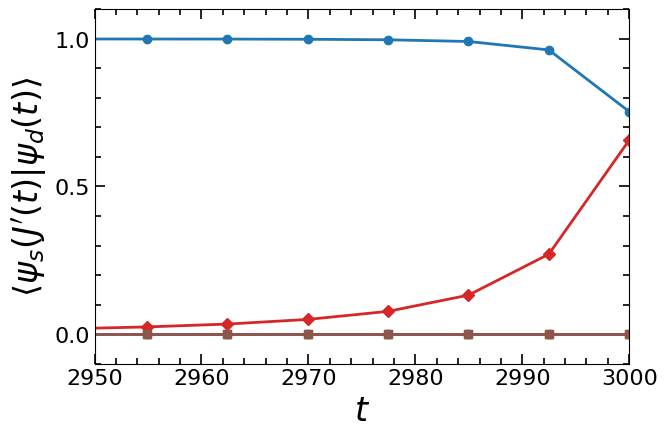

In [71]:
# データ
# Jp_list_data  (nt)
# psi_data ()

# シミュレーション
# Jp_list_sim (nt)
# psi_sim (nt, dim)

eig_idxes = [0, 1, 2, 3, 4, 5]                             
Jp_list_sim, psi_sim = simulate(N=N, J=J, hx=hx, T_cut=T_cut, nt=nt)

sel = np.asarray(eig_idxes)
overlaps = np.empty((len(sel), nt), dtype=float)

# Jp_list_dataの各要素と, Jp_list_simの差をとり, その差が最小となるidxを得る
# idx_t[m]は時刻mにおけるJpのidx
# Jp_list_sim[idx_t[m]]みたいな形で使う
idx_t = np.abs(Jp_list_data[:, None] - Jp_list_sim[None, :]).argmin(axis=0)


for m in range(nt):
    j = idx_t[m]
    v_eigs = psi_data[j, sel, :]
    v_sim = psi_sim[m]
    ov = np.abs(v_eigs @ np.conjugate(v_sim))
    overlaps[:, m] = ov

markers = ['o', 's', '^', 'D']
fig, ax = plt.subplots(figsize=(6.9, 4.6))
for i, idx in enumerate(eig_idxes):
    ax.plot(tlist, overlaps[i, :], label=f"idx = {idx}", linewidth=2.0, marker=markers[i % len(markers)])

# ax.set_xlim(tlist.min(), tlist.max())
# ax.set_xlim(0, 3000)
ax.set_xlim(2950, 3000)
ax.set_xlabel(r"$t$", fontsize=24)
ax.set_ylim(-0.1, 1.1)
ax.set_ylabel(r"$\langle\psi_s(J'(t)|\psi_d(t)\rangle$", fontsize=24)
# ax.xaxis.set_major_locator(MultipleLocator(500))
# ax.xaxis.set_minor_locator(MultipleLocator(100))
ax.xaxis.set_major_locator(MultipleLocator(10))
ax.xaxis.set_minor_locator(MultipleLocator(5))
ax.yaxis.set_major_locator(MultipleLocator(0.5))
ax.yaxis.set_minor_locator(MultipleLocator(0.1))
inward_ticks(ax)
plt.show()

OUTDIR = Path("../charts/tfim")
fig.savefig(OUTDIR/f"fidelity_N{N}_close_sqrt.pdf", bbox_inches="tight", dpi=300)